# Импорт

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  # функция предсказания
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  # отрисовка предсказаний
  plt.plot(predVal[start:start+step, 0], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

def correlate(a, b):
  # рассчет корреляции
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # ОТрисовать графики корреляции прогнозированного сигнала с с правильным
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:,0]))
    
    own_corr = []

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:,ch]))
  
    plt.plot(corr, label = 'Предсказание на '+ str(ch+1)+ 'шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()



# Light вар1 на 1 шаг

Совместил вар1 и вар2: перебил код на 1 шаг, потом их же использовал для прогнозирования на 10 шагов

In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/20 Временные ряды/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/20 Временные ряды/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data = data16_17.copy()
data = pd.concat([data16_17, data18_19])
data = np.array(data)

In [ ]:
xLen = 300
valLen = 30000

trainLen = data.shape[0]-valLen

xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, stride=1, batch_size=20)
testDataGen = TimeseriesGenerator(xTest,yTest, length=xLen, stride=1, batch_size=20)


In [ ]:
DataGen = TimeseriesGenerator(xTest,yTest, length=300, stride=1, batch_size=len(xTest))

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])
  
xVal = np.array(xVal)
yVal = np.array(yVal)

## Полносвязная сеть

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
22579/22579 [==============================] - 141s 6ms/step - loss: 0.0023 - val_loss: 2.4792e-04
Epoch 2/20
22579/22579 [==============================] - 143s 6ms/step - loss: 1.3457e-04 - val_loss: 1.8614e-05
Epoch 3/20
22579/22579 [==============================] - 139s 6ms/step - loss: 5.0774e-05 - val_loss: 1.5893e-05
Epoch 4/20
22579/22579 [==============================] - 137s 6ms/step - loss: 4.4229e-05 - val_loss: 5.0107e-05
Epoch 5/20
22579/22579 [==============================] - 142s 6ms/step - loss: 2.7785e-05 - val_loss: 1.1127e-05
Epoch 6/20
22579/22579 [==============================] - 140s 6ms/step - loss: 2.4707e-05 - val_loss: 3.5214e-05
Epoch 7/20
22579/22579 [==============================] - 138s 6ms/step - loss: 2.5047e-05 - val_loss: 6.3759e-06
Epoch 8/20
22579/22579 [==============================] - 138s 6ms/step - loss: 1.7891e-05 - val_loss: 7.3422e-06
Epoch 9/20
22579

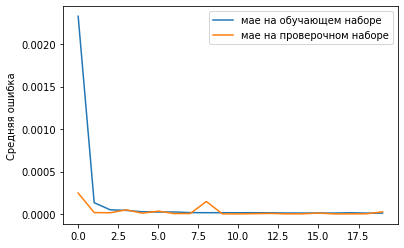

In [ ]:
modelD = Sequential()
modelD.add(Dense(150, input_shape=(xLen,5), activation='linear'))
modelD.add(Flatten())
modelD.add(Dense(1, activation='linear'))

modelD.compile(loss='mse', optimizer=Adam(lr=1e-4))

history = modelD.fit_generator(trainDataGen,
                               epochs=20,
                               verbose=1,
                               validation_data=testDataGen)

plt.plot(history.history['loss'], label='mse на обучающем наборе')
plt.plot(history.history['val_loss'], label='mse на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

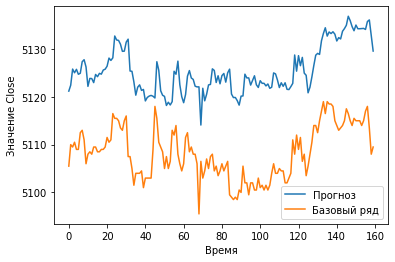

In [ ]:
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 160, 0, predVal, yValUnscaled)

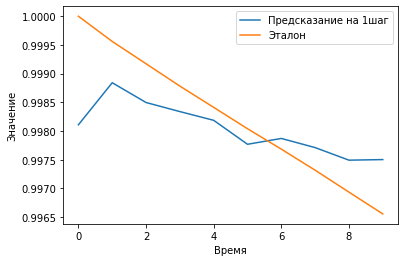

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

## Conv1d

Epoch 1/20
22579/22579 [==============================] - 1322s 59ms/step - loss: 0.0144 - val_loss: 6.1175e-05
Epoch 2/20
22579/22579 [==============================] - 1328s 59ms/step - loss: 0.0017 - val_loss: 1.0170e-04
Epoch 3/20
22579/22579 [==============================] - 1327s 59ms/step - loss: 3.3755e-04 - val_loss: 4.4865e-05
Epoch 4/20
22579/22579 [==============================] - 1318s 58ms/step - loss: 4.3476e-04 - val_loss: 9.2020e-05
Epoch 5/20
22579/22579 [==============================] - 1330s 59ms/step - loss: 1.9603e-04 - val_loss: 6.4636e-05
Epoch 6/20
22579/22579 [==============================] - 1327s 59ms/step - loss: 9.3007e-05 - val_loss: 5.6464e-06
Epoch 7/20
22579/22579 [==============================] - 1326s 59ms/step - loss: 4.2203e-05 - val_loss: 7.6072e-06
Epoch 8/20
22579/22579 [==============================] - 1336s 59ms/step - loss: 2.5145e-05 - val_loss: 7.2225e-06
Epoch 9/20
22579/22579 [==============================] - 1339s 59ms/step - loss

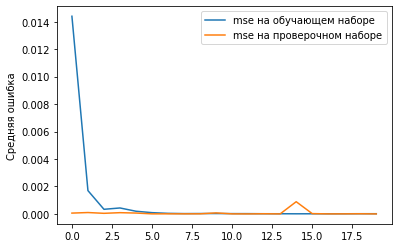

In [ ]:
modelC = Sequential()
modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation='linear'))
modelC.add(Flatten())
modelC.add(Dense(100, activation='linear'))
modelC.add(Dense(1, activation='linear'))

modelC.compile(loss='mse', optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                               epochs=20,
                               verbose=1,
                               validation_data=testDataGen)
plt.plot(history.history['loss'], label = 'mse на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'mse на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

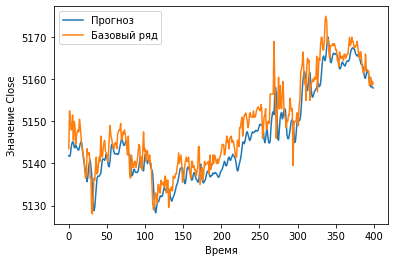

In [ ]:
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(300,400, 0, predVal-5, yValUnscaled)

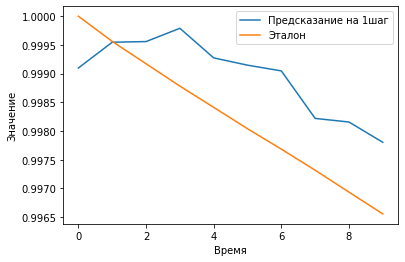

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

In [ ]:
modelD.save('/content/drive/My Drive/Colab Notebooks/20 Временные ряды/light 1 Conv1d/model_share_w.h5')
# modelD = load_model('/content/drive/My Drive/Colab Notebooks/20 Временные ряды/light 1 Conv1d/model_share_w.h5')

# Light var2 на 10 шагов

In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/20 Временные ряды/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/20 Временные ряды/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data = data16_17.copy()
data = pd.concat([data16_17, data18_19])
data = np.array(data)

In [ ]:
xLen = 300
valLen = 30000
stepsForward = 10

trainLen = data.shape[0]-valLen

xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)




In [ ]:
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           
                               length=xLen, sampling_rate=1, 
                               batch_size=20)                


testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) 

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Полносвязная сеть на 10 шагов

Epoch 1/20
22579/22579 [==============================] - 51s 2ms/step - loss: 0.0014 - val_loss: 1.8511e-05
Epoch 2/20
22579/22579 [==============================] - 52s 2ms/step - loss: 1.5575e-04 - val_loss: 2.5533e-04
Epoch 3/20
22579/22579 [==============================] - 51s 2ms/step - loss: 6.9480e-05 - val_loss: 1.3752e-05
Epoch 4/20
22579/22579 [==============================] - 51s 2ms/step - loss: 4.6700e-05 - val_loss: 1.3150e-05
Epoch 5/20
22579/22579 [==============================] - 51s 2ms/step - loss: 3.0463e-05 - val_loss: 8.3500e-06
Epoch 6/20
22579/22579 [==============================] - 51s 2ms/step - loss: 2.2532e-05 - val_loss: 8.7893e-06
Epoch 7/20
22579/22579 [==============================] - 51s 2ms/step - loss: 1.8055e-05 - val_loss: 1.0389e-05
Epoch 8/20
22579/22579 [==============================] - 53s 2ms/step - loss: 1.6574e-05 - val_loss: 9.4386e-06
Epoch 9/20
22579/22579 [==============================] - 51s 2ms/step - loss: 1.6778e-05 - val_loss

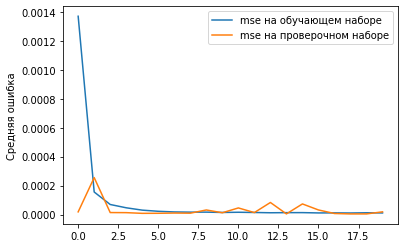

In [ ]:
modelD = Sequential()
modelD.add(Dense(150, input_shape=(xLen,5), activation='linear'))
modelD.add(Flatten())
modelD.add(Dense(10, activation='linear'))

modelD.compile(loss='mse', optimizer=Adam(lr=1e-4))

history = modelD.fit_generator(trainDataGen,
                               epochs=20,
                               verbose=1,
                               validation_data=testDataGen)

plt.plot(history.history['loss'], label='mse на обучающем наборе')
plt.plot(history.history['val_loss'], label='mse на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

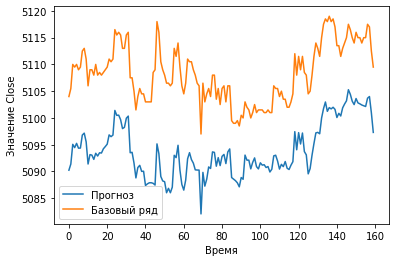

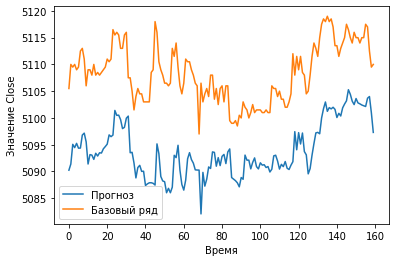

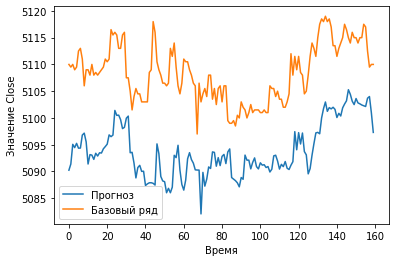

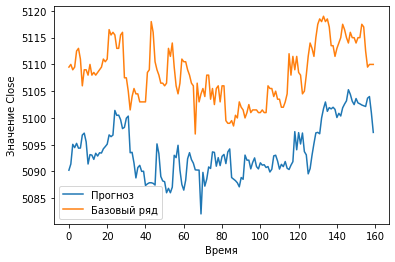

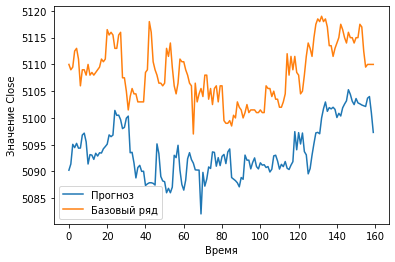

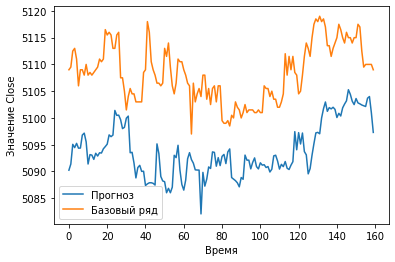

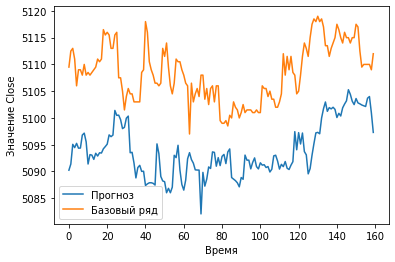

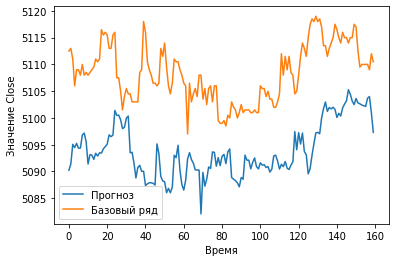

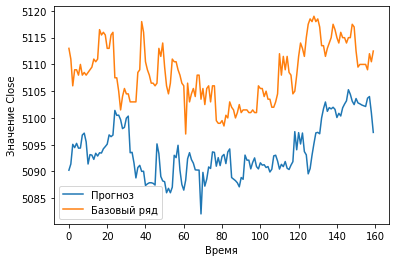

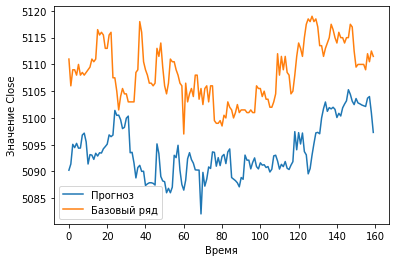

In [ ]:
for i in range(10):
  showPredict(0, 160, i, predVal, yValUnscaled)

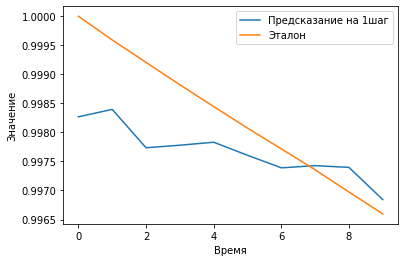

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

## Conv1D на 10 шагов

Epoch 1/20
22579/22579 [==============================] - 69s 3ms/step - loss: 0.0029 - val_loss: 1.0795e-04
Epoch 2/20
22579/22579 [==============================] - 70s 3ms/step - loss: 0.0013 - val_loss: 4.0971e-05
Epoch 3/20
22579/22579 [==============================] - 69s 3ms/step - loss: 7.5742e-04 - val_loss: 1.3059e-05
Epoch 4/20
22579/22579 [==============================] - 70s 3ms/step - loss: 3.3003e-04 - val_loss: 1.6758e-05
Epoch 5/20
22579/22579 [==============================] - 69s 3ms/step - loss: 2.5745e-04 - val_loss: 1.1209e-05
Epoch 6/20
22579/22579 [==============================] - 69s 3ms/step - loss: 2.2901e-04 - val_loss: 2.2925e-05
Epoch 7/20
22579/22579 [==============================] - 69s 3ms/step - loss: 1.0509e-04 - val_loss: 1.2225e-05
Epoch 8/20
22579/22579 [==============================] - 70s 3ms/step - loss: 9.7189e-05 - val_loss: 2.5413e-04
Epoch 9/20
22579/22579 [==============================] - 69s 3ms/step - loss: 8.0953e-05 - val_loss: 4.

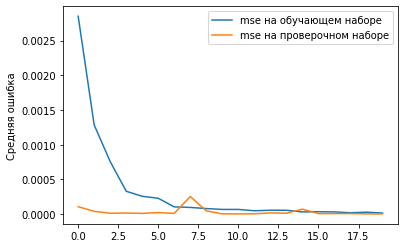

In [ ]:
modelC = Sequential()
modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation='linear'))
modelC.add(Flatten())
modelC.add(Dense(100, activation='linear'))
modelC.add(Dense(10, activation='linear'))

modelC.compile(loss='mse', optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                               epochs=20,
                               verbose=1,
                               validation_data=testDataGen)
plt.plot(history.history['loss'], label = 'mse на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'mse на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

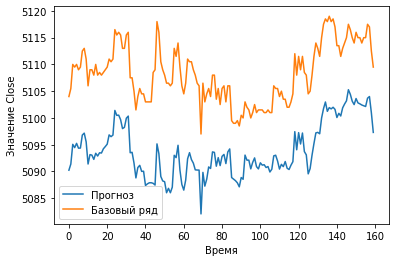

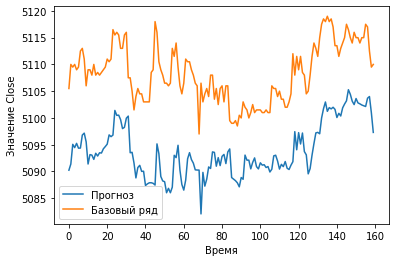

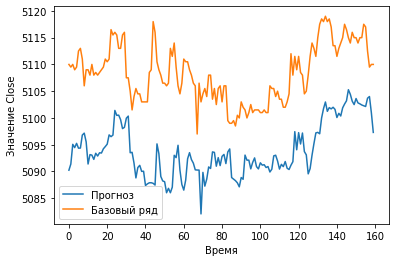

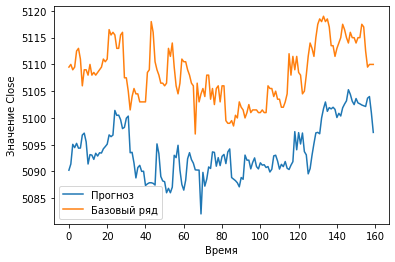

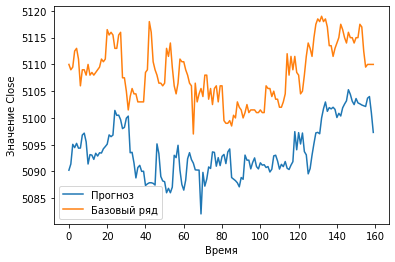

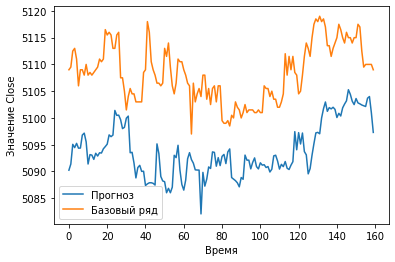

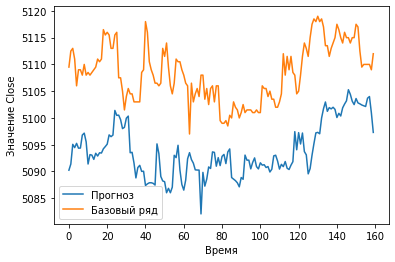

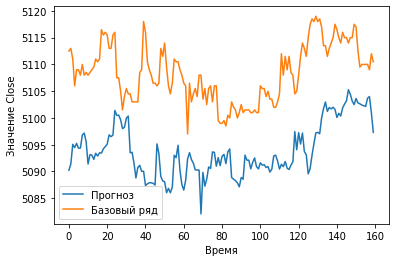

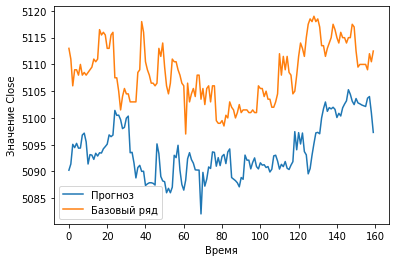

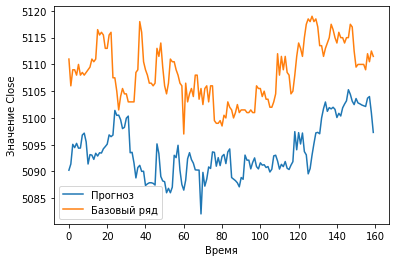

In [ ]:
for i in range(10):
  showPredict(0, 160, i, predVal, yValUnscaled)

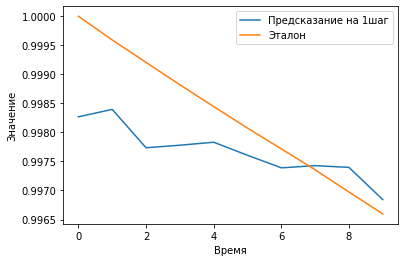

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

**Про в другом ноутбуке**